An Auto Regressive (AR) model describes the time series as a linear function of its own lags

Import packages

In [1]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa.stattools import adfuller
pd.plotting.register_matplotlib_converters()
plt.rcParams.update({'figure.figsize':(12,8), 'figure.dpi':90, 'font.size':9})

Import Financial Data and prepare datasets

In [2]:
symbols = {"BTC-USD", "GOOG", "MSFT", "KCHOL.IS", "BEEF3.SA", "PAM", "CMTOY", "IMP.JO"}

# Pull the data from January 2020 to current date
tickers = yf.Tickers(" ".join(symbols))

# Create a dictionary of Dataframes
hist = {}
for symbol in symbols:
    history = tickers.tickers[symbol].history(start="2020-01-01")
    history.rename(columns={'Open': 'y'}, inplace=True) # fbprophet will detect 'y' column
    history.index.rename('ds', inplace=True) # fbprophet will detect 'ds' dates
    history.reset_index(inplace=True) # Dates are now a column rather than an index (necessary with fbprophet)
    history['ds'] = history['ds'].dt.tz_localize(None)
    hist[symbol] = history

Define the object which will output BUY/SELL/HOLD recommandations based on a Univariate Time Series Forecasting

In [3]:
class recommender():
    ''' 
    Simulates trading of stocks based on the predictions of a statistical tool.
    
    Parameters
    ----------
    initial_stock: Initial stock owned in the simulation
    max_trade: Maximum number of stock units to be traded when a recommendation is made
    intensity: The quantity of stock traded per period is proportional to this parameter
    min_delta: Minimum predicted relative variation of the stock price to 
               recommend a BUY or SELL action.
               
    '''
    def __init__(self, initial_stock=100, max_trade = 100, intensity = 3, min_delta = 0.05, seasonal_order = False):
        self.initial_stock = initial_stock
        self.max_trade = max_trade
        self.intensity = intensity*max_trade
        self.min_delta = min_delta
        self.seasonal_order = seasonal_order
        
    def __call__(self, args):
        ''' 
        Performs a series of recommendations with the following procedure loop:
        
        1) Fits predictor to the data up to current_date from this iteration 
        2) Makes a prediction of the future stock price (after current_date)
            within a specified timeframe
        3) Makes a recommendation (BUY/SELL/HOLD) based on that prediction
        4) Updates current_date to the last date the prediction covered
    
        This sequence is looped up until a final date is reached.
            
        Parameters
        ----------
        history: 
            pd.DataFrame
            DataFrame with the timeseries data to learn from
        start_date:
            Minimum date up to which the predictor will be fitted
        end_date:
            Last date that the predictions extend to
        interval:
            Number of days separating each prediction point
        periods:
            Integer, predictor is re-fitted to the data up to current date 
            after every "periods" predictions
        
        Returns
        ----------
        A plot of the predictions compared to the real data, the financial
        balance resulting from applying the successive recommendations
        '''
        history, start_date, end_date, periods, interval = args
        
        ## Initiate all the relevant values
        # Basic attributes
        self.stock = self.initial_stock
        initial_price= float(history.loc[(history['ds']-start_date).abs().idxmin()]['y'])
        self.initial_value = self.initial_stock*initial_price # Value of Initial Stock
        self.gains = 0
        
        # Historical attributes
        self.value_history = [] # History of the variation of the value of stock being held
        self.gain_history = [] # History of gains resulting from each successive traded stock
        self.net_gain_history = [] # History of gains resulting from each successive traded stock 
                                    # net of that traded stock value at the next period
                                    # The net gain will be negative if the price of the stock sold increases 
                                    # or if the price of the stock bought decreases
        self.action_history = [] # History of each trading action performed
        
        # Prepare history and self.predictions
        history = history[['ds', 'y']]
        history = history.set_index('ds').squeeze()
        mask = history.index<start_date
        forecast, prediction, next_date = self.forecast(history, start_date, periods, interval)
        # The way the predictor is fitted to the data will be displayed
        self.predictions = pd.Series(data = forecast) 
        
        # Loop predictions until end_date
        current_date = start_date
        plt.figure()
        plt.axvline(start_date, color = 'b') # Data fitted up to that point
        while current_date < end_date:
            # Fit the predictor to the history of stock prices and forecast
            forecast, prediction, next_date = self.forecast(history, current_date, periods, interval)
            plt.axvline(next_date, color = 'g') # A green vertical line indicates that prediction was made at this date
            self.recommend(history, prediction, current_date, next_date)
            self.predictions = pd.concat([self.predictions, forecast], ignore_index = False)
            current_date = next_date
        current_price = float(history.iloc[pd.Series(history.index-current_date).abs().idxmin()])
        
        # Next, print all the relevant historical attributes from this recommender to analyze its performance
        self.totalvalue_history = [round(a+b,1) for a,b in zip(self.gain_history, self.value_history)]
        print(f'\nThe Wallet gains per trade is (positive values = SELL)\n{list(zip(self.action_history, self.gain_history))}')
        print(f'\nThe Stock Value gains per trade is\n{list(zip(self.action_history, self.value_history))}')
        print(f'\nStock + Wallet value variation after trading: \n{list(zip(self.action_history, self.totalvalue_history))}')
        print(f'\nStock + Wallet Gains related to stock traded: \n{list(zip(self.action_history, self.net_gain_history))}')
        print(f'with sum of {round(sum(self.net_gain_history), 1)}')
        print(f'\nInitial stock (Quantity = {self.initial_stock}) value on {start_date}: {round(self.initial_value, 1)}')
        print(f'\nInitial stock (Quantity = {self.initial_stock}) value on {end_date}: {round(self.initial_stock*current_price, 1)}')
        print(f'\nFinal stock (Quantity = {round(self.stock, 3)}) value on {end_date}: {round(self.value, 1)}')
        print(f'\nGains from trading: {round(self.gains, 1)}')
        print(f'\nBalance compared to initial stock value on {end_date} (value owned if no trading) = {round(self.gains + self.value - self.initial_stock*current_price,1)}')
        print(f'\nBalance compared to initial stock value on {start_date}: {round(self.gains + self.value - self.initial_value,1)}')
        
        # Plot the predictions compared to real data
        MAE, self.error = self.MAE(history, self.predictions, start_date, end_date)
        print(f'\n{MAE = }')
        rolling = history.rolling(20)
        mean, std = rolling.mean(), rolling.std()
        bolling_min = pd.Series(mean-2*std)
        bolling_max = pd.Series(mean+2*std)
        plt.title(f'Forecast and real data compared for {symbol}')
        plt.plot(self.predictions, color = 'g', label = 'Predictions')
        plt.plot(history, ':', color = 'k', label = 'History')
        plt.plot(bolling_min, color = 'b', label = 'Top of Bollinger Band')
        plt.plot(bolling_max, color = 'r', label = 'Bottom of Bollinger Band')
        plt.legend()
        plt.xlabel('Date')
        plt.xticks(fontsize = 8) 
        plt.ylabel('Open')
        plt.show()
        
    def recommend(self, history, prediction, current_date, next_date):
        '''
        Performs a recommendation based on the predictor's forecast
        
        Parameters
        ----------
        forecast: The forecast of future stock prices
        current_date: Initial date of the forecast
        next_date: Last date of the forecast
        '''
        current_price = float(history.iloc[pd.Series(history.index-current_date).abs().idxmin()])
        self.value = self.stock*current_price # Current stock value
        actual_next_price = float(history.iloc[pd.Series(history.index-next_date).abs().idxmin()])
        
        relative = (prediction-current_price)/current_price # Relative price change
        action = ["SELL", "BUY"]
        
        # Determine action to take based on predicted relative price change
        if abs(relative) >= self.min_delta:
            t = prediction/current_price
            sign = int(t>1/t) - int(t<1/t) # equals 1 if prediction>current_price, else -1
            trade = round(max(-self.stock, min(self.intensity*(max(t, 1/t)-1), self.max_trade)*sign), 6)
                # The amount of stock traded (self.intensity*(max(t, 1/t)-1)) 
                # is higher when a larger price change is predicted
            self.stock += trade
            self.gains -= trade*current_price
            self.net = trade*(actual_next_price-current_price)
            self.action_history.append(action[int(relative>0)]) # BUY or SELL
        else:
            self.net = 0
            self.action_history.append("HOLD")
            trade = 0
    
        # Update value of stock being held
        self.value_history.append(round(self.stock*actual_next_price - self.value,1))
        self.value = self.stock*actual_next_price # Updated stock value
        self.gain_history.append(round(-trade*current_price,1))
        self.net_gain_history.append(round(self.net, 1))
    
    def forecast(self, history, current_date, periods, interval):
        to_fit = history[history.index<=current_date]
        to_fit.index = pd.DatetimeIndex(to_fit.index).to_period('D')
        result = adfuller(to_fit.diff().dropna())
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        # sel = ar_select_order(to_fit, 13, glob = True, seasonal = False)
        # print(sel.ar_lags)
        # predictor = sel.model.fit()
        predictor = AutoReg(to_fit, lags = [1])
        params = predictor.fit().params
        # Predictor is now fitted to data prior to current_date
        start = history.index[pd.Series(history.index-current_date).abs().idxmin()]
        next_date = current_date+pd.Timedelta(periods*interval, 'D')
        end = history.index[pd.Series(history.index-next_date).abs().idxmin()]
        forecast = predictor.predict(params, 
                                     start = start, 
                                     end = end).to_timestamp()
        forecast = forecast[forecast.index>=start]
        prediction = forecast.iloc[-1] # Predicted future stock price
        next_date = forecast.index[-1]
        return forecast, prediction, next_date

    def MAE(self, history, forecast, start_date, end_date):
        '''Returns the Mean Absolute Error of the forecast'''
        hmask = (history.index >= start_date) & (history.index <= end_date)
        fmask = (forecast.index >= start_date) & (forecast.index <= end_date)
        error = history[hmask].subtract(forecast[fmask]).abs().dropna()
        return round(error.mean(), 1), error

Choose what to forecast

In [4]:
symbols = ["BTC-USD", "GOOG", "MSFT", "KCHOL.IS", "BEEF3.SA", "PAM", "CMTOY", "IMP.JO"]
symbol = symbols[0]
history = hist[symbol]

Set the time parameters

In [5]:
start_date = pd.to_datetime('2021-05-01') # Predictions begin after this date
end_date = pd.to_datetime('2023-10-25') # Predictions end after this date

interval = 30 # in days
periods = 2 # A recommendation is made every periods*interval days

Set the stock parameters

In [6]:
initial_stock = 10
max_trade = 10 # Maximum units of stock that can be traded after 1 recommendation is made
intensity = 3 # Price variation by 1/intensity results in trading max_trade
min_delta = 0.05 # Minimum predicted relative variation of stock price to perform a SELL or BUY action (0<min_delta<1)

Create a recommender object

In [7]:
recommend = recommender(initial_stock = initial_stock, 
                        max_trade = max_trade,
                        intensity = intensity,
                        min_delta = min_delta)

Perform the recommendation

ADF Statistic: -6.779324
p-value: 0.000000
ADF Statistic: -6.779324
p-value: 0.000000
ADF Statistic: -5.006906
p-value: 0.000022
ADF Statistic: -6.969778
p-value: 0.000000
ADF Statistic: -27.351780
p-value: 0.000000
ADF Statistic: -28.337388
p-value: 0.000000
ADF Statistic: -29.007779
p-value: 0.000000
ADF Statistic: -30.080988
p-value: 0.000000
ADF Statistic: -31.266687
p-value: 0.000000
ADF Statistic: -32.214316
p-value: 0.000000
ADF Statistic: -33.224778
p-value: 0.000000
ADF Statistic: -34.152524
p-value: 0.000000
ADF Statistic: -10.590141
p-value: 0.000000
ADF Statistic: -10.917900
p-value: 0.000000
ADF Statistic: -11.226059
p-value: 0.000000
ADF Statistic: -11.466264
p-value: 0.000000
ADF Statistic: -11.768044
p-value: 0.000000

The Wallet gains per trade is (positive values = SELL)
[('BUY', -372189.6), ('HOLD', 0.0), ('HOLD', 0.0), ('HOLD', 0.0), ('HOLD', 0.0), ('HOLD', 0.0), ('HOLD', 0.0), ('BUY', -81436.9), ('BUY', -75069.7), ('BUY', -77857.2), ('BUY', -80165.3), ('BUY', -4804

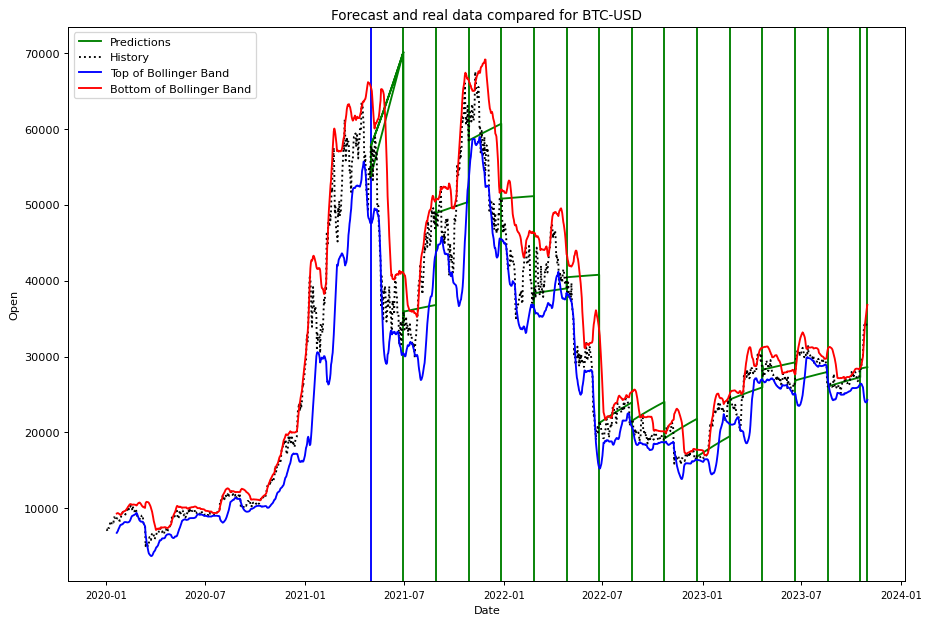

In [8]:
args = (history, start_date, end_date, periods, interval)
recommend(args) # performs the recommendation

The above results show that AutoReg was not able to fit the data well.